In [20]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI # llm 모델 사용하기 위한 모듈
from langchain_core.messages import HumanMessage, AIMessage # message 양식 처리를 위한 모듈

from dotenv import load_dotenv
load_dotenv()

True

### 1. 복잡한 State를 정의

In [21]:
class UserProfile(TypedDict):
    name : str
    age : Optional[int]
    hobbies : list[str]
    location : str
    is_complete : bool

llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0.2
)

### 2. 단계별 정보를 수집하는 노드

In [75]:
# 1. 이름 수집하기
def collect_name(state : UserProfile) -> UserProfile:
    """이 노드는 유저가 이름을 차요준 이렇게 써도 되지만
    내이름은 차요준이야 이렇게 했을 때도 -> 차요준 으로 되도록 llm 처리
    하려는 노드"""
    print("Step 1: 이름 수집 단계 진행")

    # 필요한 로직이 있다면 추가해주세요.
    name = state.get("name", "홍길동") # 만약 내가 내이름은 차요준이야 라고 적었다면 name = "내이름은 차요준이야"
    response = llm.invoke([HumanMessage(content=f"{name}에서 이름을 추출해서 이름만 반환하세요.")])

    print("원래 입력한 값은", name, "처리한 값은", response)


    return {
        **state,
        "name" : response.content
    }

# 2. 나이 수집하기
def collection_age(state : UserProfile) -> UserProfile:
    """이 노드는 나이가 28 이렇게 써도 되지만
    내나이는 28살이야라고 했을 때 -> 28 으로 되도록 llm 처리"""
    print("Step 2: 나이 수집 단계 진행")

    # 필요한 로직이 있다면 추가하기
    age = state.get("age", 28)
    response = llm.invoke([HumanMessage(content=f"{age}에서 나이만 추출해서 나이만 반환하세요")])

    print("원래 입력 값은", age, "처리한 값은", response)


    return {
        **state,
        "age" : response.content
    }


# 3. 취미 수집하기
def collection_hobbies(state : UserProfile) -> UserProfile:
    """이 노드는 나의 취미는 달리기야 라고 써도 되지만
    나의 취미는 달리기 라고 했을 때 -> 달리기 으로 되도록 llm 처리"""
    print("Step 3: 취미 수집 단계 진행")
    hobbies = state.get("hobbies", ["달리기", "영화시청"])
    response = llm.invoke([HumanMessage(content=f"{hobbies}에서 취미만 추출해서 취미만 반환하세요")])

    print("원래 입력 값은", hobbies, "처리한 값은", response)

    return {
        **state,
        "hobbies" : response.content
    }

# 4. 위치 수집하기
def collection_location(state: UserProfile) -> UserProfile:
    """이 노드는 나의 위치는 정배리야 라고 써도 되지만
    나의 위치는 정배리야 했을 때 -> 정배리 으로 되도록 llm 처리"""
    print("Step 4: 위치 수집 단계 진행")
    location = state.get("location", "정배리")
    response = llm.invoke([HumanMessage(content=f"{location}에서 위치만 추출해서 위치만 반환하세요")])

    print("원래 입력 값은", location, "처리한 값은", response)

    return {
        "location" : response.content
    }

# 5. 완료 상태 확인
def collection_is_complete(state: UserProfile) -> UserProfile:
    """이 노드는 모든 필수 정보가 수집 되었는지 확인하고 
    완료 상태를 설정하는 노드입니다."""

    # 필수 필드들이 모두 채워져 있는지 확인
    is_complete = all([
        state.get("name"), # 이름이 있는지
        state.get("age"), # 나이가 있는지
        state.get("hobbies"), # 취미가 있는지
        state.get("location") # 위치가 있는지
    ])

    return {
        **state,
        "is_complete" : is_complete
    }

### 3. 그래프 생성

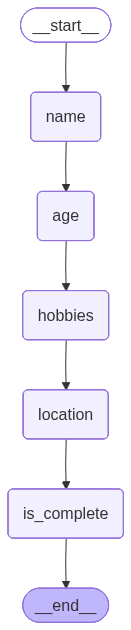

In [76]:
workflow = StateGraph(UserProfile)

# 노드 추가
workflow.add_node("name", collect_name)
workflow.add_node("age", collection_age)
workflow.add_node("hobbies", collection_hobbies)
workflow.add_node("location", collection_location)
workflow.add_node("is_complete", collection_is_complete)

# 시작점
workflow.add_edge(START, "name")

# 엣지
workflow.add_edge("name", "age")
workflow.add_edge("age", "hobbies")
workflow.add_edge("hobbies", "location")
workflow.add_edge("location", "is_complete")

# 끝점
workflow.add_edge("is_complete", END)

# 컴파일
app = workflow.compile()
app

# workflow.__dict__

In [78]:
init_state = {
    "name" : "나는 차요준입니다.",
    "age" : "나는 28살 이야",
    "hobbies" : ["나는 달리기를 좋아해", "나는 영화시청을 좋아해"],
    "location" : "나는 정배리에서 살고있어요.",
    "is_complete" : True
}

result = app.invoke(init_state)
print(result)

Step 1: 이름 수집 단계 진행
원래 입력한 값은 나는 차요준입니다. 처리한 값은 content='차요준' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 24, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CVePeuPl4Nnuzj4TRNau5CZriJrlE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--f231e4c3-0e33-4936-9ea0-74df028623f6-0' usage_metadata={'input_tokens': 24, 'output_tokens': 3, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Step 2: 나이 수집 단계 진행
원래 입력 값은 나는 28살 이야 처리한 값은 content='28' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tok

In [ ]:
result["name"]

'28'

In [53]:
result["age"]

'28'

In [52]:
result["hobbies"]

"['달리기']"

In [79]:
result["location"]

'정배리'

In [80]:
result["is_complete"]

True